In [147]:
using CSV, DataFrames, Statistics, Random, Plots, JuMP, Gurobi, Distributions, Random, Metrics
using StatsBase: sample

#import sklearn functions 
using ScikitLearn
@sk_import linear_model: LogisticRegression
@sk_import linear_model: LinearRegression
@sk_import metrics:accuracy_score;
@sk_import metrics:precision_score;
@sk_import metrics:recall_score;
@sk_import metrics:mean_squared_error;

include("utils.jl");

In [130]:
#todo change X_shifted that it is added later
mutable struct RegressionClass
    name::String
    X::DataFrame
    X_shifted::DataFrame
    y::Vector{Float64}
    y_shifted::Vector{Float64}
    covar_parameters::Vector{Any}
    covar_dist_type::String
    lambas_range::Vector{Float64}
    train_test_prop::Float64
    train_val_prop::Float64
    num_runs::Float64
end

### preprocess functions

In [131]:
function generate_covariate_shift(rc::RegressionClass, seed = 123)
    #set a seed for distribution
    Random.seed!(seed)

    if rc.covar_dist_type == "Normal"
        col_means = mean(Matrix(rc.X), dims=1)
        col_vars = var(Matrix(rc.X), dims = 1)

        random_values = zeros(size(rc.X))

        for col_index in 1:size(rc.X, 2)
            col_mean = col_means[col_index]
            col_var = col_vars[col_index]
            col_shift = rand(Normal(col_mean + rc.covar_parameters[1] , sqrt(col_var) * rc.covar_parameters[2]), (size(rc.X, 1), 1))
            random_values[:, col_index] = col_shift
        end

        X_shifted = Matrix(rc.X) .+ random_values;
        rc.X_shifted = DataFrame(X_shifted, Symbol.(names(rc.X)))
    end
end

generate_covariate_shift (generic function with 2 methods)

In [132]:
function train_test_split(rc::RegressionClass, random_seed)
    
    Random.seed!(random_seed)

    num_indices = round(Int, rc.train_test_prop * length(rc.y))
    train_indices = sample(1:length(rc.y), num_indices, replace=false)
    test_indices = setdiff(1:length(rc.y), train_indices)
    
    X_train, y_train = Matrix(rc.X)[train_indices, :], rc.y[train_indices]
    X_test, y_test = Matrix(rc.X_shifted)[test_indices, :], rc.y_shifted[test_indices]
    
    return (X_train, y_train), (X_test, y_test)
end

train_test_split (generic function with 1 method)

### Stable Regression

In [133]:
function train_val_opt_split(rc::RegressionClass, X_train_full, y_train_full, beta_opt, weights = "nothing")

    residuals = y_train_full - X_train_full * beta_opt

    if weights == "nothing"
        sorted_indices = sortperm(abs.(residuals), rev=true)
    else 
        residuals_weights = [residuals[i] * weights[i] for i in 1:length(weights)]
        sorted_indices = sortperm(abs.(residuals_weights), rev=true)
    end

    num_train_points = round(Int, rc.train_val_prop * length(sorted_indices))

    train_indices = sorted_indices[1:num_train_points]

    val_indices = setdiff(1:length(y_train_full), train_indices)

    X_train = X_train_full[train_indices, :] 
    y_train = y_train_full[train_indices]

    X_val = X_train_full[val_indices, :]
    y_val = y_train_full[val_indices]

    return X_train, y_train, X_val, y_val
end


train_val_opt_split (generic function with 2 methods)

In [134]:
#todo: could change X, y to X_train, y_train
function get_optimized_split(rc::RegressionClass, X, y, lambda, weights="nothing")
    # to do: should n be an attribute
    n, p = size(X)
    k = round(Int, n * rc.train_val_prop)
    
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, theta)
    @variable(model, u[1:n] >= 0)
    @variable(model, beta[1:p])
    @variable(model, w[1:p])
    @objective(model, Min, k * theta + sum(u) + lambda * sum(w))
    
    for i in 1:p
        @constraint(model, w[i] >= beta[i])
        @constraint(model, w[i] >= -beta[i])
    end 
    
    for i in 1:n
        if weights == "nothing"
            @constraint(model, theta + u[i] >= y[i] - sum(X[i, :].*beta))
            @constraint(model, theta + u[i] >= -(y[i] - sum(X[i, :].*beta)))
        else 
            @constraint(model, theta + u[i] >=  weights[i] * (y[i] - sum(X[i, :].*beta)))
            @constraint(model, theta + u[i] >= - weights[i] * (y[i] - sum(X[i, :].*beta)))
        end 
    end
    
    # for i in 1:n
    # weight_term = (weights == "nothing") ? 1 : weights[i]
    # @constraint(model, theta + u[i] >= weight_term * (y[i] - sum(X[i, :].*beta)))
    # @constraint(model, theta + u[i] >= -weight_term * (y[i] - sum(X[i, :].*beta)))
    # end
    
    optimize!(model)
    return value(theta), value.(u), value.(beta), value.(w) 
end

get_optimized_split (generic function with 2 methods)

In [135]:
function get_optimized_split_test_score(rc::RegressionClass, X_full_train, y_full_train, X_test, y_test, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf
    
    for lambda in rc.lambas_range
        # Get optimized split
        _, _, betas, _ = get_optimized_split(rc, X_full_train, y_full_train, lambda, weights)
        X_train, y_train, X_val, y_val = train_val_opt_split(rc, X_full_train, y_full_train, betas, weights)
        
        # Predict on validation set
        y_pred_val =  X_val * betas
        val_mse_i = mse(y_val, y_pred_val)
        
        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = betas
        end
    end

    #get mse on test set for best performing model 
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)

    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model))
    end

    return mse_test_mse
end

get_optimized_split_test_score (generic function with 3 methods)

In [136]:
function get_random_test_score(rc::RegressionClass, X_full_train, y_full_train, X_test, y_test, seed_value, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf

    (X_train, y_train), (X_val, y_val) = 
        IAI.split_data(:regression, X_full_train, y_full_train, train_proportion=rc.train_val_prop, seed=seed_value)

    for lambda in rc.lambas_range
        beta_star = LassoRegression(X_train, y_train, lambda, weights)

        y_pred_val = X_val * beta_star
        val_mse_i = mse(y_val, y_pred_val)

        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = beta_star
        end
    end

    #get test mse score on best performing model
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)

    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model.coef_) + length(best_model.intercept_))
    end
   
    return mse_test_mse
end


get_random_test_score (generic function with 3 methods)

In [137]:
#todo: deal with prints (false)
#todo: add what is returned to instance 
function repeat_four_methods(rc::RegressionClass)

    random_mse_test_scores, random_weights_mse_test_scores = [], []
    optim_mse_test_scores, optim_weights_mse_test_scores = [], []

    for random_seed in 1:rc.num_runs
        random_seed = Int(random_seed) #need to be int 
        
        #split and normalise data
        (X_train, y_train), (X_test, y_test) = train_test_split(rc, random_seed)
        
        X_train_norm, X_test_norm = normalize_data(X_train, X_test)
        X_train_norm, X_test_norm = add_intercept(X_train_norm), add_intercept(X_test_norm)

        weights = get_weights(X_train_norm, X_test_norm, false)

        if random_seed % 10 == 0
            println(random_seed)
        end

        # println("Starting Randomization")
        random_mse_test_score = get_random_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, 209, "nothing", false)
        push!(random_mse_test_scores, random_mse_test_score)
        
        # println("Starting Randomization with covariate weights")
        random_weights_mse_test_score = get_random_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, 209, weights, false)
        push!(random_weights_mse_test_scores, random_weights_mse_test_score)
        
        # println("Starting Optimization")
        optim_mse_test_score = get_optimized_split_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, "nothing", false)
        push!(optim_mse_test_scores, optim_mse_test_score)
        
        # println("Starting Optimization with covariate weights")
        optim_weights_mse_test_score = get_optimized_split_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, weights, false)
        push!(optim_weights_mse_test_scores, optim_weights_mse_test_score)
    end 
    
    return random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores
end


repeat_four_methods (generic function with 1 method)

## Test with DATA


In [138]:
#hyperparameters
num_runs = 100
train_fraction = 0.7 
test_fraction = 0.9
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1];

### Try with concrete data

In [120]:
X_full, y_full = get_concrete_data()

test_instance = RegressionClass("conrete", X_full, X_full, y_full, y_full, [2, 1/4], "Normal", lambdas, test_fraction, train_fraction, num_runs);
#todo: call during instantiation 

generate_covariate_shift(test_instance);

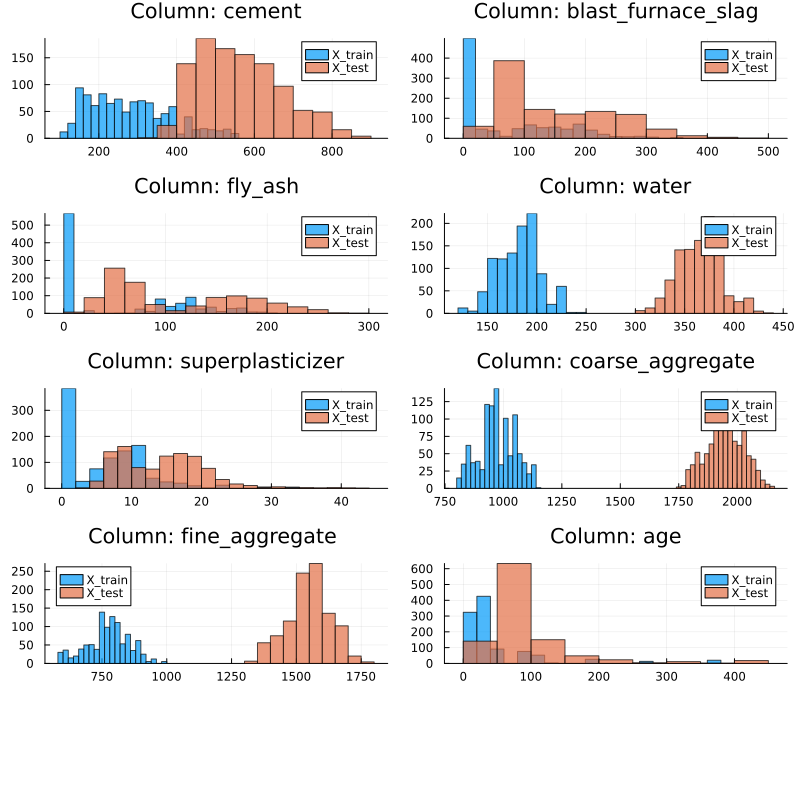

In [121]:
plot_covariate_shit(test_instance.X, test_instance.X_shifted)

In [122]:
random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores = repeat_four_methods(test_instance)

improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11

-381.7029219230081

In [22]:
println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: 8.395631485560365
% improvement in mse with weight: -150.32913403891405


In [39]:
df_results = DataFrame(OPT_MSE_1000runs = optim_mse_test_scores, OPT_W_Weights_MSE_1000runs = optim_weights_mse_test_scores, RAND_MSE_1000runs = random_mse_test_scores, RAND_W_Weights_MSE_1000runs = random_mse_test_scores);
CSV.write("../data/results/concrete_mse_$(test_instance.num_runs)runs_with$(test_instance.train_val_prop)TrainFrac.csv", df_results)

"../data/results/concrete_mse_1000.0runs_with0.7TrainFrac.csv"

### Try with computer hardware dataset

In [59]:
X_full, y_full = get_comp_hard_data()
comp_hard_instance= RegressionClass("comp_hard", X_full, X_full, y_full, y_full, [0.5, 0.1], "Normal", lambdas, test_fraction, train_fraction, num_runs);
#todo: call during instantiation 
generate_covariate_shift(comp_hard_instance);

In [45]:
random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores = repeat_four_methods(comp_hard_instance)

improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11

Excessive output truncated after 526087 bytes.

-56.58783272544811

In [47]:
println("Dataset $(comp_hard_instance.name ) % improvement in mse with no weight: ", improv_no_weight)
println("Dataset $(comp_hard_instance.name ) % improvement in mse with weight: ", improv_with_weight)

Dataset comp_hard % improvement in mse with no weight: -1.206043533244057
Dataset comp_hard % improvement in mse with weight: -56.58783272544811


In [48]:
df_results = DataFrame(OPT_MSE_1000runs = optim_mse_test_scores, OPT_W_Weights_MSE_1000runs = optim_weights_mse_test_scores, RAND_MSE_1000runs = random_mse_test_scores, RAND_W_Weights_MSE_1000runs = random_mse_test_scores);
CSV.write("../data/results/$(comp_hard_instance.name)_mse_$(comp_hard_instance.num_runs)runs_with$(comp_hard_instance.train_val_prop)TrainFrac.csv", df_results)

"../data/results/comp_hard_mse_1000.0runs_with0.7TrainFrac.csv"

### Abalone dataset

In [157]:
X_full, y_full = get_abalone_data()
abalone_instance= RegressionClass("abalone", X_full, X_full, y_full, y_full, [0.5, 0.1], "Normal", lambdas, test_fraction, train_fraction, num_runs);
#todo: call during instantiation 
generate_covariate_shift(abalone_instance);

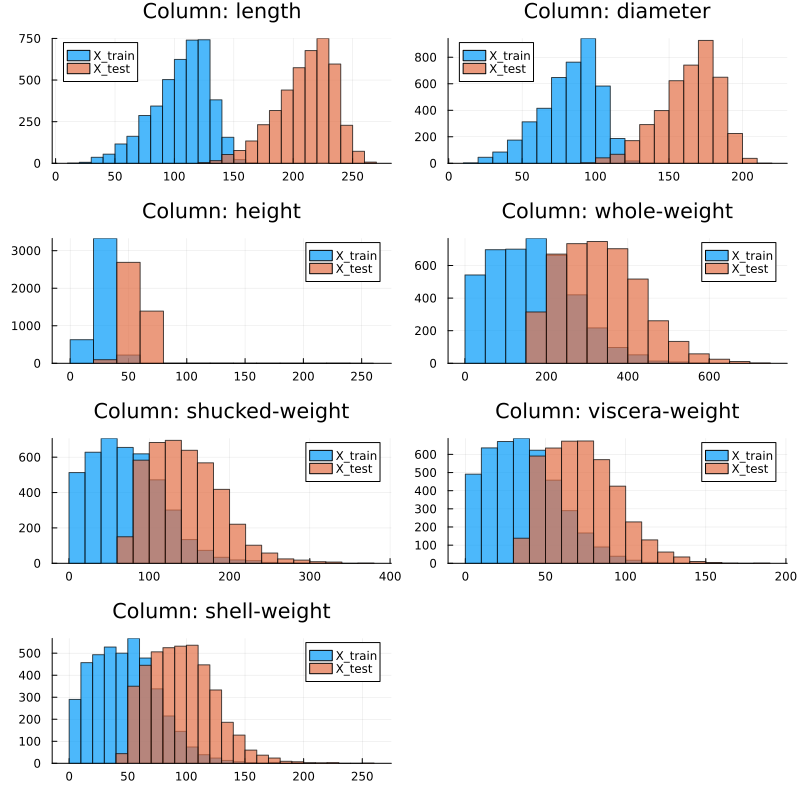

In [158]:
plot_covariate_shit(abalone_instance.X, abalone_instance.X_shifted)

In [159]:
random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores = repeat_four_methods(abalone_instance)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11

In [55]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("Dataset $(abalone_instance.name ) % improvement in mse with no weight: ", improv_no_weight)
println("Dataset $(abalone_instance.name ) % improvement in mse with weight: ", improv_with_weight)

Dataset abalone % improvement in mse with no weight: -4.567959127031164
Dataset abalone % improvement in mse with weight: 43.806538780706234


In [54]:
df_results = DataFrame(OPT_MSE_1000runs = optim_mse_test_scores, OPT_W_Weights_MSE_1000runs = optim_weights_mse_test_scores, RAND_MSE_1000runs = random_mse_test_scores, RAND_W_Weights_MSE_1000runs = random_mse_test_scores);
CSV.write("../data/results/$(abalone_instance.name)_mse_$(abalone_instance.num_runs)runs_with$(abalone_instance.train_val_prop)TrainFrac.csv", df_results)

"../data/results/abalone_mse_1000.0runs_with0.7TrainFrac.csv"

### Test with synthetic data

- https://jmlr.org/papers/volume8/sugiyama07a/sugiyama07a.pdf

- page 7

In [73]:
(X_train, y_train), (X_test, y_test) = generate_synthetic_data(100)
synthetic_instance = RegressionClass("synthetic", X_train, X_test, y_train, y_test, [0.5, 0.1], "Normal", lambdas, test_fraction, train_fraction, num_runs);

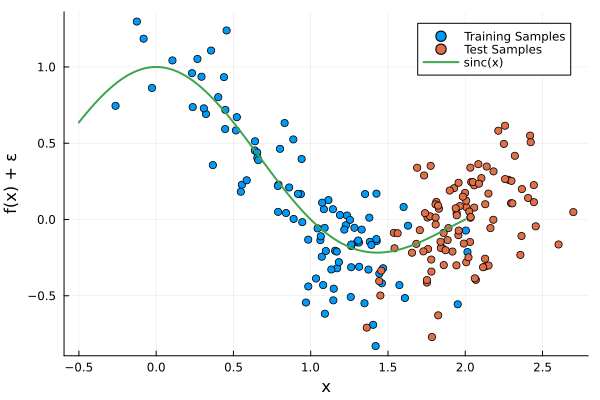

In [74]:
f(x) = sinc(x)
# Visualize the training samples
scatter(Matrix(X_train), y_train, label="Training Samples", xlabel="x", ylabel="f(x) + ε")

# Visualize the test samples
scatter!(Matrix(X_test), y_test, label="Test Samples")

# Visualize the sinc function
x_values = range(-0.5, stop=2, length=500)
plot!(x_values, f.(x_values), label="sinc(x)", linewidth=2)

# Show the plot
display(Plots.plot!())

In [85]:
random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores = repeat_four_methods(synthetic_instance);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
(10,)
(10,)helloSet parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
(10,)
(10,)helloSet parameter Username
Academic license - for non-commerci

In [86]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: -1.6639645716756672
% improvement in mse with weight: 73.55329149029758


### synthetic data 2

In [148]:
(X_train, y_train), (X_test, y_test)  = generate_synthetic_data_2(200)
synthetic_instance2 = RegressionClass("synthetic2", X_train, X_test, y_train, y_test, [0.5, 0.1], "Normal", lambdas, test_fraction, train_fraction, num_runs);

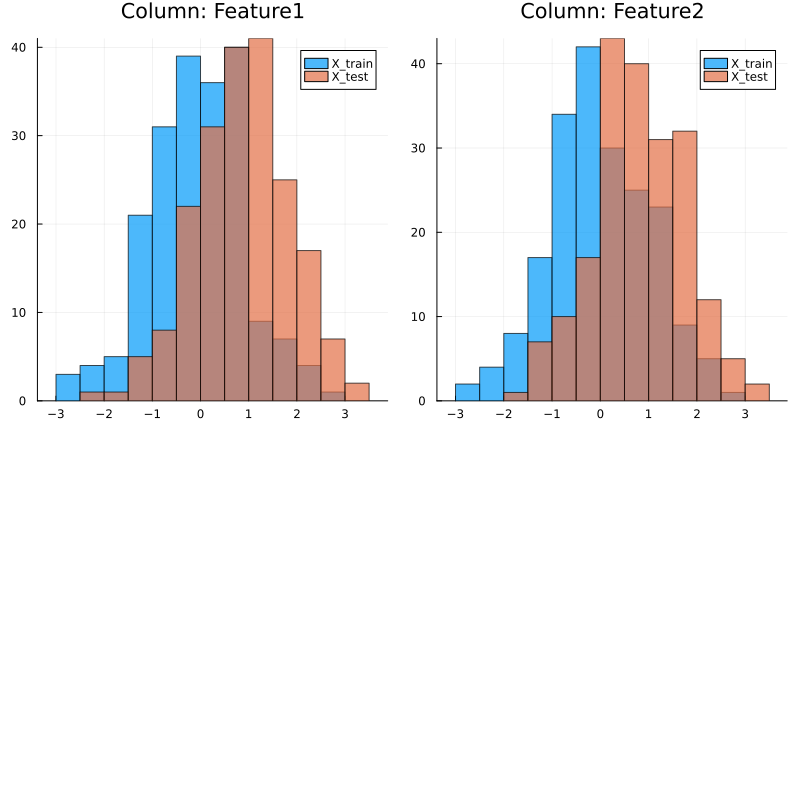

In [151]:
plot_covariate_shit(synthetic_instance2.X, synthetic_instance2.X_shifted)

In [153]:
random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores = repeat_four_methods(synthetic_instance2);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11

In [154]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: -2.761652717271093
% improvement in mse with weight: 64.82096253014926
